In [7]:
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [2]:
# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False)

In [3]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = base_model.predict(preprocessed_img)
    flattened_features = features.flatten()
    return flattened_features

In [4]:
if os.path.exists('yanport_dataset/features_ResNet.csv'):
    df = pd.read_csv('yanport_dataset/features_ResNet.csv')
else:
    fake_dir = 'yanport_dataset/ELA_FAKE'
    real_dir = 'yanport_dataset/ELA_REAL'
    
    fake_features = [extract_features(os.path.join(fake_dir, img_path)) for img_path in os.listdir(fake_dir)]
    real_features = [extract_features(os.path.join(real_dir, img_path)) for img_path in os.listdir(real_dir)]
    
    # Create labels for the features
    fake_labels = [1] * len(fake_features)
    real_labels = [0] * len(real_features)
    
    # Combine the features and labels
    X = np.array(fake_features + real_features)
    y = np.array(fake_labels + real_labels)
    
    # create df from X and y and save it to csv
    df = pd.DataFrame(X)
    df['label'] = y
    df.to_csv('yanport_dataset/features_ResNet.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

In [5]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a GridSearchCV object
grid_search = RandomizedSearchCV(rf, param_grid, cv=5, n_iter=50, verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(best_params)

In [12]:
if os.path.exists('model_2.pkl'):
    rf = joblib.load('model_2.pkl')
else:
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    joblib.dump(rf, 'model_2.pkl')

In [13]:
# Test the classifier
y_pred = rf.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
recalls = recall_score(y_test, y_pred)
precisions = precision_score(y_test, y_pred)
f1_scores = f1_score(y_test, y_pred)
print('Accuracy:', round(accuracy, 2)) 
print('Recalls:', round(recalls, 2))
print('Precisions:', round(precisions, 2))
print('F1 Scores:', round(f1_scores, 2))

Accuracy: 0.89
Recalls: 0.88
Precisions: 0.9
F1 Scores: 0.89


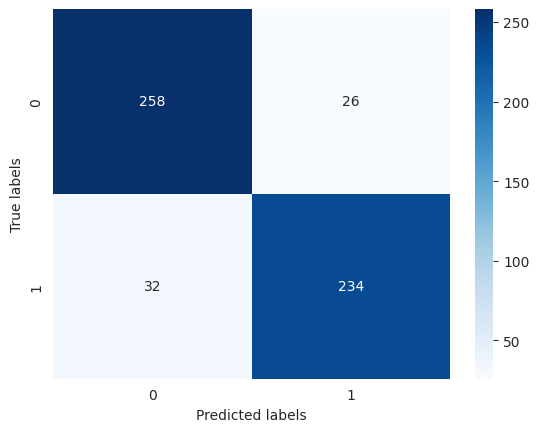

In [16]:
# Plot the confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()